In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

In [3]:
emotion_table = {0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger', 5: 'disgust', 6: 'fear', 7: 'contempt'}

In [4]:
processed_train_images = np.load('../input/mxnet-processed/fer_train_processed_images.npy')
processed_train_labels = np.load('../input/mxnet-processed/fer_train_processed_labels.npy')

In [5]:
print(processed_train_images.shape)

(25045, 1, 64, 64)


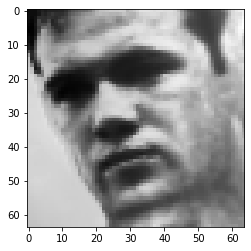

In [5]:
plt.imshow(processed_train_images[987].reshape(64,64), cmap='gray')

In [6]:
processed_test_images = np.load('../input/mxnet-processed/fer_test_processed_images.npy')
processed_test_labels = np.load('../input/mxnet-processed/fer_test_processed_labels.npy')
processed_val_images = np.load('../input/mxnet-processed/fer_val_processed_images.npy')
processed_val_labels = np.load('../input/mxnet-processed/fer_val_processed_labels.npy')

In [7]:
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [8]:
net.hybridize()

In [9]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

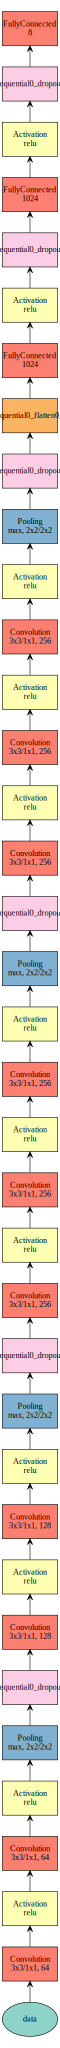

In [10]:
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)

In [11]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
batch_size = 32
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0025, 'momentum': 0.9})

In [12]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [13]:
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)

In [14]:
epochs = 50

train_accuracies = []
losses = []
preds = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))

[17:28:51] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Epoch 0. Loss: 1.8321475, Train_acc 0.3486923537632262, Val_acc 0.36979003447195236
Epoch 1. Loss: 1.4398143, Train_acc 0.38534637652225995, Val_acc 0.38827953619555
Epoch 2. Loss: 1.8832674, Train_acc 0.4228388899980036, Val_acc 0.4415543716703228
Epoch 3. Loss: 1.4772896, Train_acc 0.4788580555000998, Val_acc 0.49169539329363837
Epoch 4. Loss: 1.3547, Train_acc 0.530564983030545, Val_acc 0.5481040426198683
Epoch 5. Loss: 1.5934595, Train_acc 0.5777201038131363, Val_acc 0.5988718270134754
Epoch 6. Loss: 1.3970608, Train_acc 0.6239968057496507, Val_acc 0.645565653400188
Epoch 7. Loss: 1.2806911, Train_acc 0.6723896985426233, Val_acc 0.6875587590097149
Epoch 8. Loss: 0.790384, Train_acc 0.6934717508484728, Val_acc 0.6985271074898151
Epoch 9. Loss: 0.64439785, Train_acc 0.7138750249550808, Val_acc 0.7214039486054529
Epoch 10. Loss: 1.1929691, Train_acc 0.7359552804951088, Val_acc 0.7323722970855531
Epoch 11. Loss: 0.44208735, Train_acc 0.7547215012976642, Val_acc 0.7329990598558446
Epoch

In [15]:
predictions = []
acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    prediction = nd.argmax(output, axis=1)
    predictions.append(prediction)
    acc.update(preds=prediction, labels=label)
print("Test Accuracy - ", acc.get()[1])

Test Accuracy -  0.810965890978642


In [16]:
processedPreds = []
for list1 in predictions:
    for list2 in list1:
        processedPreds.append(list2)

# Precision:

In [17]:
trueNeutral = 0
falseNeutral = 0
trueHappiness = 0
falseHappiness = 0
trueSurprise = 0
falseSurprise = 0
trueSadness = 0
falseSadness = 0
trueAnger = 0
falseAnger = 0
trueDisgust = 0
falseDisgust = 0
trueFear = 0
falseFear = 0
trueContempt = 0
falseContempt = 0

for i in range(len(test_labels)):
    if test_labels[i] == 0 and processedPreds[i] == 0:
        trueNeutral += 1
    elif processedPreds[i] == 0 and test_labels[i] != 0:
        falseNeutral += 1
    elif test_labels[i] == 1 and processedPreds[i] == 1:
        trueHappiness += 1
    elif processedPreds[i] == 1 and test_labels[i] != 1:
        falseHappiness += 1
    elif test_labels[i] == 2 and processedPreds[i] == 2:
        trueSurprise += 1
    elif processedPreds[i] == 2 and test_labels[i] != 2:
        falseSurprise += 1
    elif test_labels[i] == 3 and processedPreds[i] == 3:
        trueSadness += 1
    elif processedPreds[i] == 3 and test_labels[i] != 3:
        falseSadness += 1
    elif test_labels[i] == 4 and processedPreds[i] == 4:
        trueAnger += 1
    elif processedPreds[i] == 4 and test_labels[i] != 4:
        falseAnger += 1
    elif test_labels[i] == 5 and processedPreds[i] == 5:
        trueDisgust += 1
    elif processedPreds[i] == 5 and test_labels[i] != 5:
        falseDisgust += 1
    elif test_labels[i] == 6 and processedPreds[i] == 6:
        trueFear += 1
    elif processedPreds[i] == 6 and test_labels[i] != 6:
        falseFear += 1
    elif test_labels[i] == 7 and processedPreds[i] == 7:
        trueContempt += 1
    elif processedPreds[i] == 7 and test_labels[i] != 7:
        falseContempt += 1

In [18]:
neutralPrecision = (trueNeutral)/(trueNeutral+falseNeutral)
happinessPrecision = (trueHappiness)/(trueHappiness+falseHappiness)
surprisePrecision = (trueSurprise)/(trueSurprise+falseSurprise)
sadnessPrecision = (trueSadness)/(trueSadness+falseSadness)
angerPrecision = (trueAnger)/(trueAnger+falseAnger)
disgustPrecision = (trueDisgust)/(trueDisgust+falseDisgust)
fearPrecision = (trueFear)/(trueFear+falseFear)
contemptPrecision = (trueContempt)/(trueContempt+falseContempt)
print(f"Precison for Neutral expression is: {neutralPrecision}.")
print(f"Precison for Happy expression is: {happinessPrecision}.")
print(f"Precison for Surprised expression is: {surprisePrecision}.")
print(f"Precison for Sad expression is: {sadnessPrecision}.")
print(f"Precison for Angry expression is: {angerPrecision}.")
print(f"Precison for Disgusted expression is: {disgustPrecision}.")
print(f"Precison for Fear expression is: {fearPrecision}.")
print(f"Precison for Contempt expression is: {contemptPrecision}.")

Precison for Neutral expression is: 0.8060230292294066.
Precison for Happy expression is: 0.9014238773274917.
Precison for Surprised expression is: 0.8451776649746193.
Precison for Sad expression is: 0.6299212598425197.
Precison for Angry expression is: 0.7966804979253111.
Precison for Disgusted expression is: 0.3333333333333333.
Precison for Fear expression is: 0.7017543859649122.
Precison for Contempt expression is: 0.0.


# Recall:

In [19]:
trueNeutral = 0
falseNeutral = 0
trueHappiness = 0
falseHappiness = 0
trueSurprise = 0
falseSurprise = 0
trueSadness = 0
falseSadness = 0
trueAnger = 0
falseAnger = 0
trueDisgust = 0
falseDisgust = 0
trueFear = 0
falseFear = 0
trueContempt = 0
falseContempt = 0

for i in range(len(test_labels)):
    if test_labels[i] == 0 and processedPreds[i] == 0:
        trueNeutral += 1
    elif processedPreds[i] != 0 and test_labels[i] == 0:
        falseNeutral += 1
    elif test_labels[i] == 1 and processedPreds[i] == 1:
        trueHappiness += 1
    elif processedPreds[i] != 1 and test_labels[i] == 1:
        falseHappiness += 1
    elif test_labels[i] == 2 and processedPreds[i] == 2:
        trueSurprise += 1
    elif processedPreds[i] != 2 and test_labels[i] == 2:
        falseSurprise += 1
    elif test_labels[i] == 3 and processedPreds[i] == 3:
        trueSadness += 1
    elif processedPreds[i] != 3 and test_labels[i] == 3:
        falseSadness += 1
    elif test_labels[i] == 4 and processedPreds[i] == 4:
        trueAnger += 1
    elif processedPreds[i] != 4 and test_labels[i] == 4:
        falseAnger += 1
    elif test_labels[i] == 5 and processedPreds[i] == 5:
        trueDisgust += 1
    elif processedPreds[i] != 5 and test_labels[i] == 5:
        falseDisgust += 1
    elif test_labels[i] == 6 and processedPreds[i] == 6:
        trueFear += 1
    elif processedPreds[i] != 6 and test_labels[i] == 6:
        falseFear += 1
    elif test_labels[i] == 7 and processedPreds[i] == 7:
        trueContempt += 1
    elif processedPreds[i] != 7 and test_labels[i] == 7:
        falseContempt += 1

In [20]:
neutralRecall = (trueNeutral)/(trueNeutral+falseNeutral)
happinessRecall = (trueHappiness)/(trueHappiness+falseHappiness)
surpriseRecall = (trueSurprise)/(trueSurprise+falseSurprise)
sadnessRecall = (trueSadness)/(trueSadness+falseSadness)
angerRecall = (trueAnger)/(trueAnger+falseAnger)
disgustRecall = (trueDisgust)/(trueDisgust+falseDisgust)
fearRecall = (trueFear)/(trueFear+falseFear)
contemptRecall = (trueContempt)/(trueContempt+falseContempt)
print(f"Recall for Neutral expression is: {neutralRecall}.")
print(f"Recall for Happy expression is: {happinessRecall}.")
print(f"Recall for Surprised expression is: {surpriseRecall}.")
print(f"Recall for Sad expression is: {sadnessRecall}.")
print(f"Recall for Angry expression is: {angerRecall}.")
print(f"Recall for Disgusted expression is: {disgustRecall}.")
print(f"Recall for Fear expression is: {fearRecall}.")
print(f"Recall for Contempt expression is: {contemptRecall}.")

Recall for Neutral expression is: 0.840258541089566.
Recall for Happy expression is: 0.922645739910314.
Recall for Surprised expression is: 0.8451776649746193.
Recall for Sad expression is: 0.6282722513089005.
Recall for Angry expression is: 0.7137546468401487.
Recall for Disgusted expression is: 0.375.
Recall for Fear expression is: 0.46511627906976744.
Recall for Contempt expression is: 0.0.


# F1-Score:

In [21]:
f1Neutral = (2*neutralPrecision*neutralRecall)/(neutralPrecision+neutralRecall)
f1Happy = (2*happinessPrecision*happinessRecall)/(happinessPrecision+happinessRecall)
f1Surprise = (2*surprisePrecision*surpriseRecall)/(surprisePrecision+surpriseRecall)
f1Sad = (2*sadnessPrecision*sadnessRecall)/(sadnessPrecision+sadnessRecall)
f1Angry = (2*angerPrecision*angerRecall)/(angerPrecision+angerRecall)
f1Disgust = (2*disgustPrecision*disgustRecall)/(disgustPrecision+disgustRecall)
f1Fear = (2*fearPrecision*fearRecall)/(fearPrecision+fearRecall)
print(f"F1-Score for Neutral expression is: {f1Neutral}.")
print(f"F1-Score for Happy expression is: {f1Happy}.")
print(f"F1-Score for Surprised expression is: {f1Surprise}.")
print(f"F1-Score for Sad expression is: {f1Sad}.")
print(f"F1-Score for Angry expression is: {f1Angry}.")
print(f"F1-Score for Disgusted expression is: {f1Disgust}.")
print(f"F1-Score for Fear expression is: {f1Fear}.")

F1-Score for Neutral expression is: 0.8227848101265822.
F1-Score for Happy expression is: 0.9119113573407202.
F1-Score for Surprised expression is: 0.8451776649746193.
F1-Score for Sad expression is: 0.6290956749672346.
F1-Score for Angry expression is: 0.7529411764705882.
F1-Score for Disgusted expression is: 0.35294117647058826.
F1-Score for Fear expression is: 0.5594405594405595.


# AUC-ROC Curves:

## 1. Neutral

AUC Score for Neutral expression is: 0.8668186571075872.


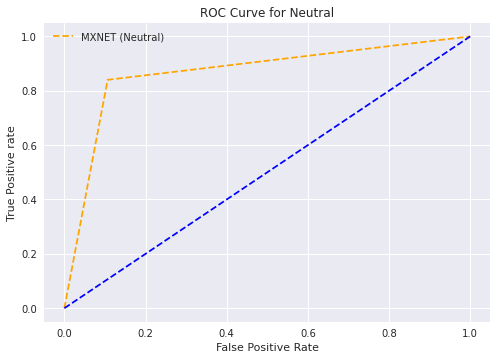

In [22]:
testNeutral = []
predsNeutral = []
for i in range(len(test_labels)):
    if test_labels[i] == 0 and processedPreds[i] == 0:
        testNeutral.append(1)
        predsNeutral.append(1)
    elif test_labels[i] == 0 and processedPreds[i] != 0:
        testNeutral.append(1)
        predsNeutral.append(0)
    elif test_labels[i] != 0 and processedPreds[i] != 0:
        testNeutral.append(0)
        predsNeutral.append(0)
    elif test_labels[i] != 0 and processedPreds[i] == 0:
        testNeutral.append(0)
        predsNeutral.append(1)
        
fpr, tpr, thresh = roc_curve(testNeutral, predsNeutral, pos_label=1)
random_probs = [0 for i in range(len(testNeutral))]
p_fpr, p_tpr, _ = roc_curve(testNeutral, random_probs, pos_label=1)
auc_score = roc_auc_score(testNeutral, predsNeutral)
print(f"AUC Score for Neutral expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Neutral)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Neutral')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Neutral',dpi=300)
plt.show()

## 2. Happiness

AUC Score for Happy expression is: 0.9412783265253131.


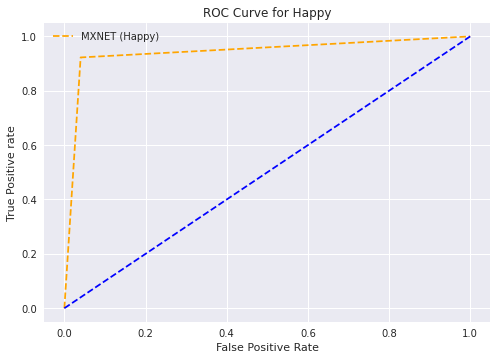

In [23]:
testHappy = []
predsHappy = []
for i in range(len(test_labels)):
    if test_labels[i] == 1 and processedPreds[i] == 1:
        testHappy.append(1)
        predsHappy.append(1)
    elif test_labels[i] == 1 and processedPreds[i] != 1:
        testHappy.append(1)
        predsHappy.append(0)
    elif test_labels[i] != 1 and processedPreds[i] != 1:
        testHappy.append(0)
        predsHappy.append(0)
    elif test_labels[i] != 1 and processedPreds[i] == 1:
        testHappy.append(0)
        predsHappy.append(1)
        
fpr, tpr, thresh = roc_curve(testHappy, predsHappy, pos_label=1)
random_probs = [0 for i in range(len(testHappy))]
p_fpr, p_tpr, _ = roc_curve(testHappy, random_probs, pos_label=1)
auc_score = roc_auc_score(testHappy, predsHappy)
print(f"AUC Score for Happy expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Happy)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Happy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Happy',dpi=300)
plt.show()

## 3. Surprise

AUC Score for Surprise expression is: 0.9114696199462962.


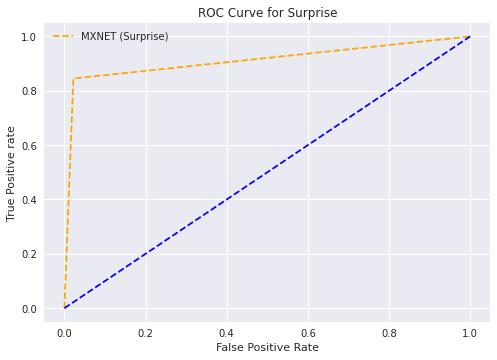

In [24]:
testSurprise = []
predsSurprise = []
for i in range(len(test_labels)):
    if test_labels[i] == 2 and processedPreds[i] == 2:
        testSurprise.append(1)
        predsSurprise.append(1)
    elif test_labels[i] == 2 and processedPreds[i] != 2:
        testSurprise.append(1)
        predsSurprise.append(0)
    elif test_labels[i] != 2 and processedPreds[i] != 2:
        testSurprise.append(0)
        predsSurprise.append(0)
    elif test_labels[i] != 2 and processedPreds[i] == 2:
        testSurprise.append(0)
        predsSurprise.append(1)
        
fpr, tpr, thresh = roc_curve(testSurprise, predsSurprise, pos_label=1)
random_probs = [0 for i in range(len(testSurprise))]
p_fpr, p_tpr, _ = roc_curve(testSurprise, random_probs, pos_label=1)
auc_score = roc_auc_score(testSurprise, predsSurprise)
print(f"AUC Score for Surprise expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Surprise)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Surprise')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Surprise',dpi=300)
plt.show()

## 4. Sadness

AUC Score for Sadness expression is: 0.7885462889938332.


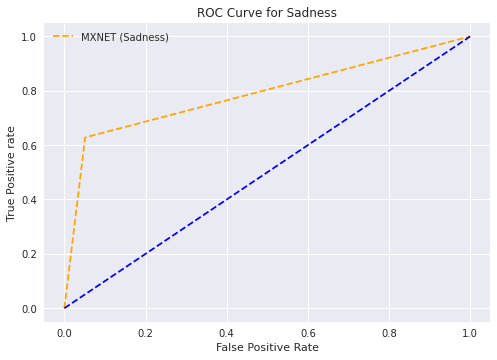

In [25]:
testSadness = []
predsSadness = []
for i in range(len(test_labels)):
    if test_labels[i] == 3 and processedPreds[i] == 3:
        testSadness.append(1)
        predsSadness.append(1)
    elif test_labels[i] == 3 and processedPreds[i] != 3:
        testSadness.append(1)
        predsSadness.append(0)
    elif test_labels[i] != 3 and processedPreds[i] != 3:
        testSadness.append(0)
        predsSadness.append(0)
    elif test_labels[i] != 3 and processedPreds[i] == 3:
        testSadness.append(0)
        predsSadness.append(1)
        
fpr, tpr, thresh = roc_curve(testSadness, predsSadness, pos_label=1)
random_probs = [0 for i in range(len(testSadness))]
p_fpr, p_tpr, _ = roc_curve(testSadness, random_probs, pos_label=1)
auc_score = roc_auc_score(testSadness, predsSadness)
print(f"AUC Score for Sadness expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Sadness)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Sadness')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Sadness',dpi=300)
plt.show()

## 5. Anger

AUC Score for Angry expression is: 0.8483347850658205.


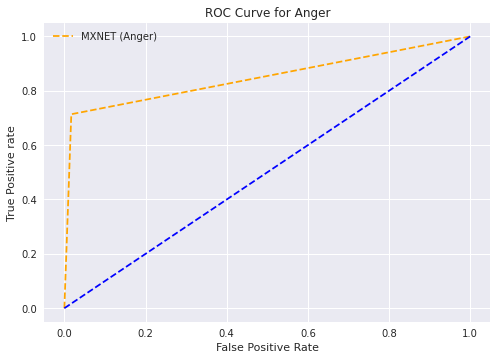

In [26]:
testAnger = []
predsAnger = []
for i in range(len(test_labels)):
    if test_labels[i] == 4 and processedPreds[i] == 4:
        testAnger.append(1)
        predsAnger.append(1)
    elif test_labels[i] == 4 and processedPreds[i] != 4:
        testAnger.append(1)
        predsAnger.append(0)
    elif test_labels[i] != 4 and processedPreds[i] != 4:
        testAnger.append(0)
        predsAnger.append(0)
    elif test_labels[i] != 4 and processedPreds[i] == 4:
        testAnger.append(0)
        predsAnger.append(1)
        
fpr, tpr, thresh = roc_curve(testAnger, predsAnger, pos_label=1)
random_probs = [0 for i in range(len(testAnger))]
p_fpr, p_tpr, _ = roc_curve(testAnger, random_probs, pos_label=1)
auc_score = roc_auc_score(testAnger, predsAnger)
print(f"AUC Score for Angry expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Anger)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Anger')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Anger',dpi=300)
plt.show()

## 6. Disgust 

AUC Score for Disgusted expression is: 0.6855775392502402.


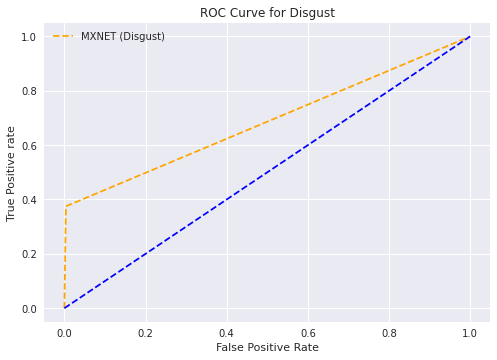

In [27]:
testDisgust = []
predsDisgust = []
for i in range(len(test_labels)):
    if test_labels[i] == 5 and processedPreds[i] == 5:
        testDisgust.append(1)
        predsDisgust.append(1)
    elif test_labels[i] == 5 and processedPreds[i] != 5:
        testDisgust.append(1)
        predsDisgust.append(0)
    elif test_labels[i] != 5 and processedPreds[i] != 5:
        testDisgust.append(0)
        predsDisgust.append(0)
    elif test_labels[i] != 5 and processedPreds[i] == 5:
        testDisgust.append(0)
        predsDisgust.append(1)
        
fpr, tpr, thresh = roc_curve(testDisgust, predsDisgust, pos_label=1)
random_probs = [0 for i in range(len(testDisgust))]
p_fpr, p_tpr, _ = roc_curve(testDisgust, random_probs, pos_label=1)
auc_score = roc_auc_score(testDisgust, predsDisgust)
print(f"AUC Score for Disgusted expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Disgust)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Disgust')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Disgust',dpi=300)
plt.show()

## 7. Fear

AUC Score for Fear expression is: 0.7297721677223632.


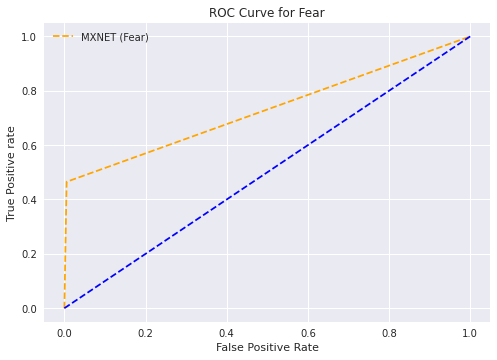

In [28]:
testFear = []
predsFear = []
for i in range(len(test_labels)):
    if test_labels[i] == 6 and processedPreds[i] == 6:
        testFear.append(1)
        predsFear.append(1)
    elif test_labels[i] == 6 and processedPreds[i] != 6:
        testFear.append(1)
        predsFear.append(0)
    elif test_labels[i] != 6 and processedPreds[i] != 6:
        testFear.append(0)
        predsFear.append(0)
    elif test_labels[i] != 6 and processedPreds[i] == 6:
        testFear.append(0)
        predsFear.append(1)
        
fpr, tpr, thresh = roc_curve(testFear, predsFear, pos_label=1)
random_probs = [0 for i in range(len(testFear))]
p_fpr, p_tpr, _ = roc_curve(testFear, random_probs, pos_label=1)
auc_score = roc_auc_score(testFear, predsFear)
print(f"AUC Score for Fear expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Fear)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Fear')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Fear',dpi=300)
plt.show()

## 8. Contempt

AUC Score for Contempt expression is: 0.49935938500960925.


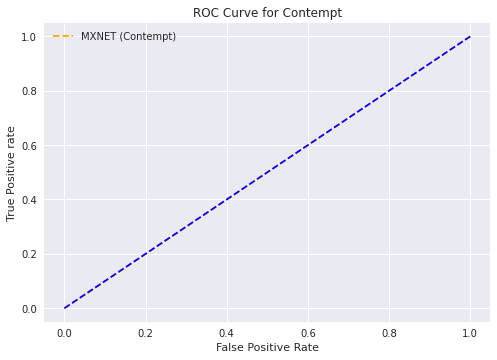

In [29]:
testContempt = []
predsContempt = []
for i in range(len(test_labels)):
    if test_labels[i] == 7 and processedPreds[i] == 7:
        testContempt.append(1)
        predsContempt.append(1)
    elif test_labels[i] == 7 and processedPreds[i] != 7:
        testContempt.append(1)
        predsContempt.append(0)
    elif test_labels[i] != 7 and processedPreds[i] != 7:
        testContempt.append(0)
        predsContempt.append(0)
    elif test_labels[i] != 7 and processedPreds[i] == 7:
        testContempt.append(0)
        predsContempt.append(1)
        
fpr, tpr, thresh = roc_curve(testContempt, predsContempt, pos_label=1)
random_probs = [0 for i in range(len(testContempt))]
p_fpr, p_tpr, _ = roc_curve(testContempt, random_probs, pos_label=1)
auc_score = roc_auc_score(testContempt, predsContempt)
print(f"AUC Score for Contempt expression is: {auc_score}.")

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color = 'orange', label='MXNET (Contempt)')
plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
plt.title('ROC Curve for Contempt')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC Contempt',dpi=300)
plt.show()

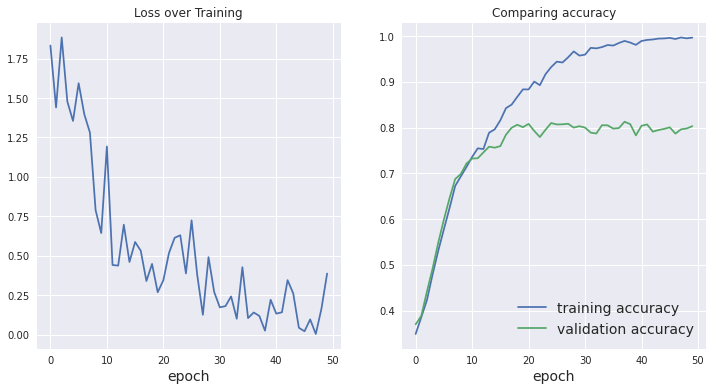

In [30]:
epochs = range(len(train_accuracies))
f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)
fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)
fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")
p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)

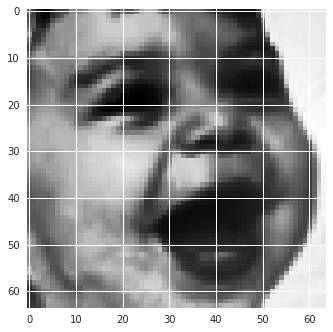

In [31]:
plt.imshow(processed_test_images[98].reshape(64,64), cmap='gray')

In [32]:
print("Actual Emotion - ", emotion_table[test_labels[90]])

Actual Emotion -  surprise


In [33]:
output = net(mx.nd.array(processed_test_images[90].reshape(1,1,64,64)).as_in_context(ctx))

In [34]:
print("Predicted Emotion - ", emotion_table[nd.argmax(output, axis=1).asnumpy()[0]])

Predicted Emotion -  surprise


In [35]:
net.save_parameters("parameters")

In [36]:
net.export("FER")